In [3]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

In [ ]:
# model v4

# Democrats vs Republicans
democrats_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/democrats_before_2016_interim.model")
democrats_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/democrats_2017_2020_interim.model")
democrats_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/democrats_2021_2024_interim.model")
liberal_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/liberal_before_2016_interim.model")
liberal_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/liberal_2017_2020_interim.model")
liberal_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/liberal_2021_2024_interim.model")
republican_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/republican_before_2016_interim.model")
republican_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/republican_2017_2020_interim.model")
republican_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/republican_2021_2024_interim.model")
conservative_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/conservative_before_2016_interim.model")
conservative_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/conservative_2017_2020_interim.model")
conservative_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/conservative_2021_2024_interim.model")
backpacking_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/backpacking_before_2016_interim.model")
backpacking_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/backpacking_2017_2020_interim.model")
backpacking_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/backpacking_2021_2024_interim.model")
vagabond_before_2016 = gensim.models.Word2Vec.load("models/model_v4/interim/vagabond_before_2016_interim.model")
vagabond_2017_2020 = gensim.models.Word2Vec.load("models/model_v4/interim/vagabond_2017_2020_interim.model")
vagabond_2021_2024 = gensim.models.Word2Vec.load("models/model_v4/interim/vagabond_2021_2024_interim.model")

# Define output directory
output_dir = "output/v4"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016
compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    conservative_before_2016,
    "republican", 
    "conservative",
    "before_2016",
    output_file=f"{output_dir}/republican_conservative_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    democrats_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_before_2016, 
    democrats_before_2016,
    "liberal", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/liberal_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_before_2016, 
    vagabond_before_2016,
    "backpacking", 
    "vagabond",
    "before_2016",
    output_file=f"{output_dir}/backpacking_vagabond_before_2016.csv"
)

# 2017-2020
compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    conservative_2017_2020,
    "republican", 
    "conservative",
    "2017_2020",
    output_file=f"{output_dir}/republican_conservative_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    democrats_2017_2020,
    "republican", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/republican_democrats_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_2017_2020, 
    democrats_2017_2020,
    "liberal", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/liberal_democrats_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_2017_2020, 
    vagabond_2017_2020,
    "backpacking", 
    "vagabond",
    "2017_2020",
    output_file=f"{output_dir}/backpacking_vagabond_2017_2020.csv"
)

# 2021-2024
compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    conservative_2021_2024,
    "republican", 
    "conservative",
    "2021_2024",
    output_file=f"{output_dir}/republican_conservative_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    democrats_2021_2024,
    "republican", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/republican_democrats_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_2021_2024, 
    democrats_2021_2024,
    "liberal", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/liberal_democrats_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_2021_2024, 
    vagabond_2021_2024,
    "backpacking", 
    "vagabond",
    "2021_2024",
    output_file=f"{output_dir}/backpacking_vagabond_2021_2024.csv"
)


print("\nAnalysis complete. Generated 12 comparison files.")


Comparing models:
before_2016: Common vocabulary between republican and conservative: 14360 words
Results saved to output/v4/republican_conservatives_before_2016.csv
before_2016: Common vocabulary between republican and democrats: 10606 words
Results saved to output/v4/republican_democrats_before_2016.csv
before_2016: Common vocabulary between liberal and democrats: 9819 words
Results saved to output/v4/liberal_democrats_before_2016.csv
before_2016: Common vocabulary between backpacking and vagabond: 5683 words
Results saved to output/v4/backpacking_vagabond_before_2016.csv
2017_2020: Common vocabulary between republican and conservative: 14716 words
Results saved to output/v4/republican_conservatives_2017_2020.csv
2017_2020: Common vocabulary between republican and democrats: 14334 words
Results saved to output/v4/republican_democrats_2017_2020.csv
2017_2020: Common vocabulary between liberal and democrats: 10318 words
Results saved to output/v4/liberal_democrats_2017_2020.csv
2017_2

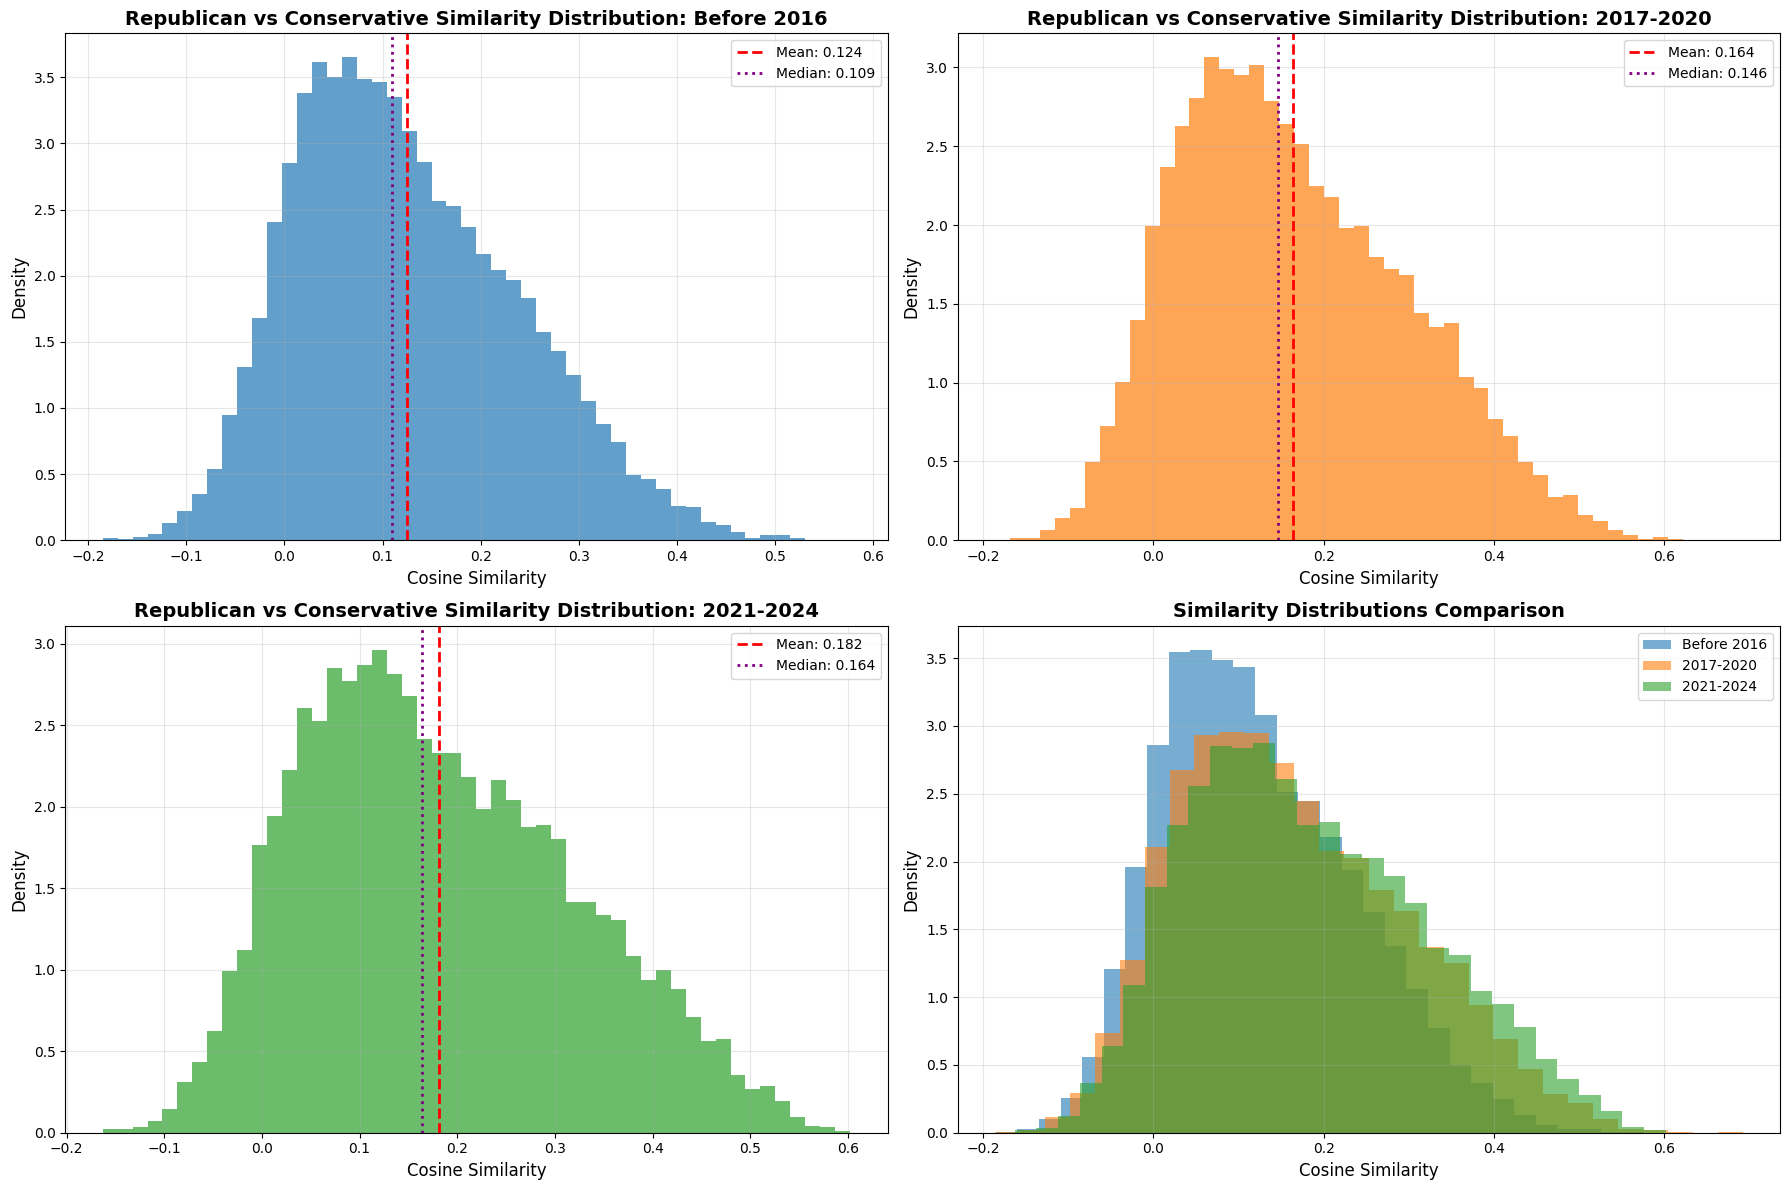

<Figure size 640x480 with 0 Axes>

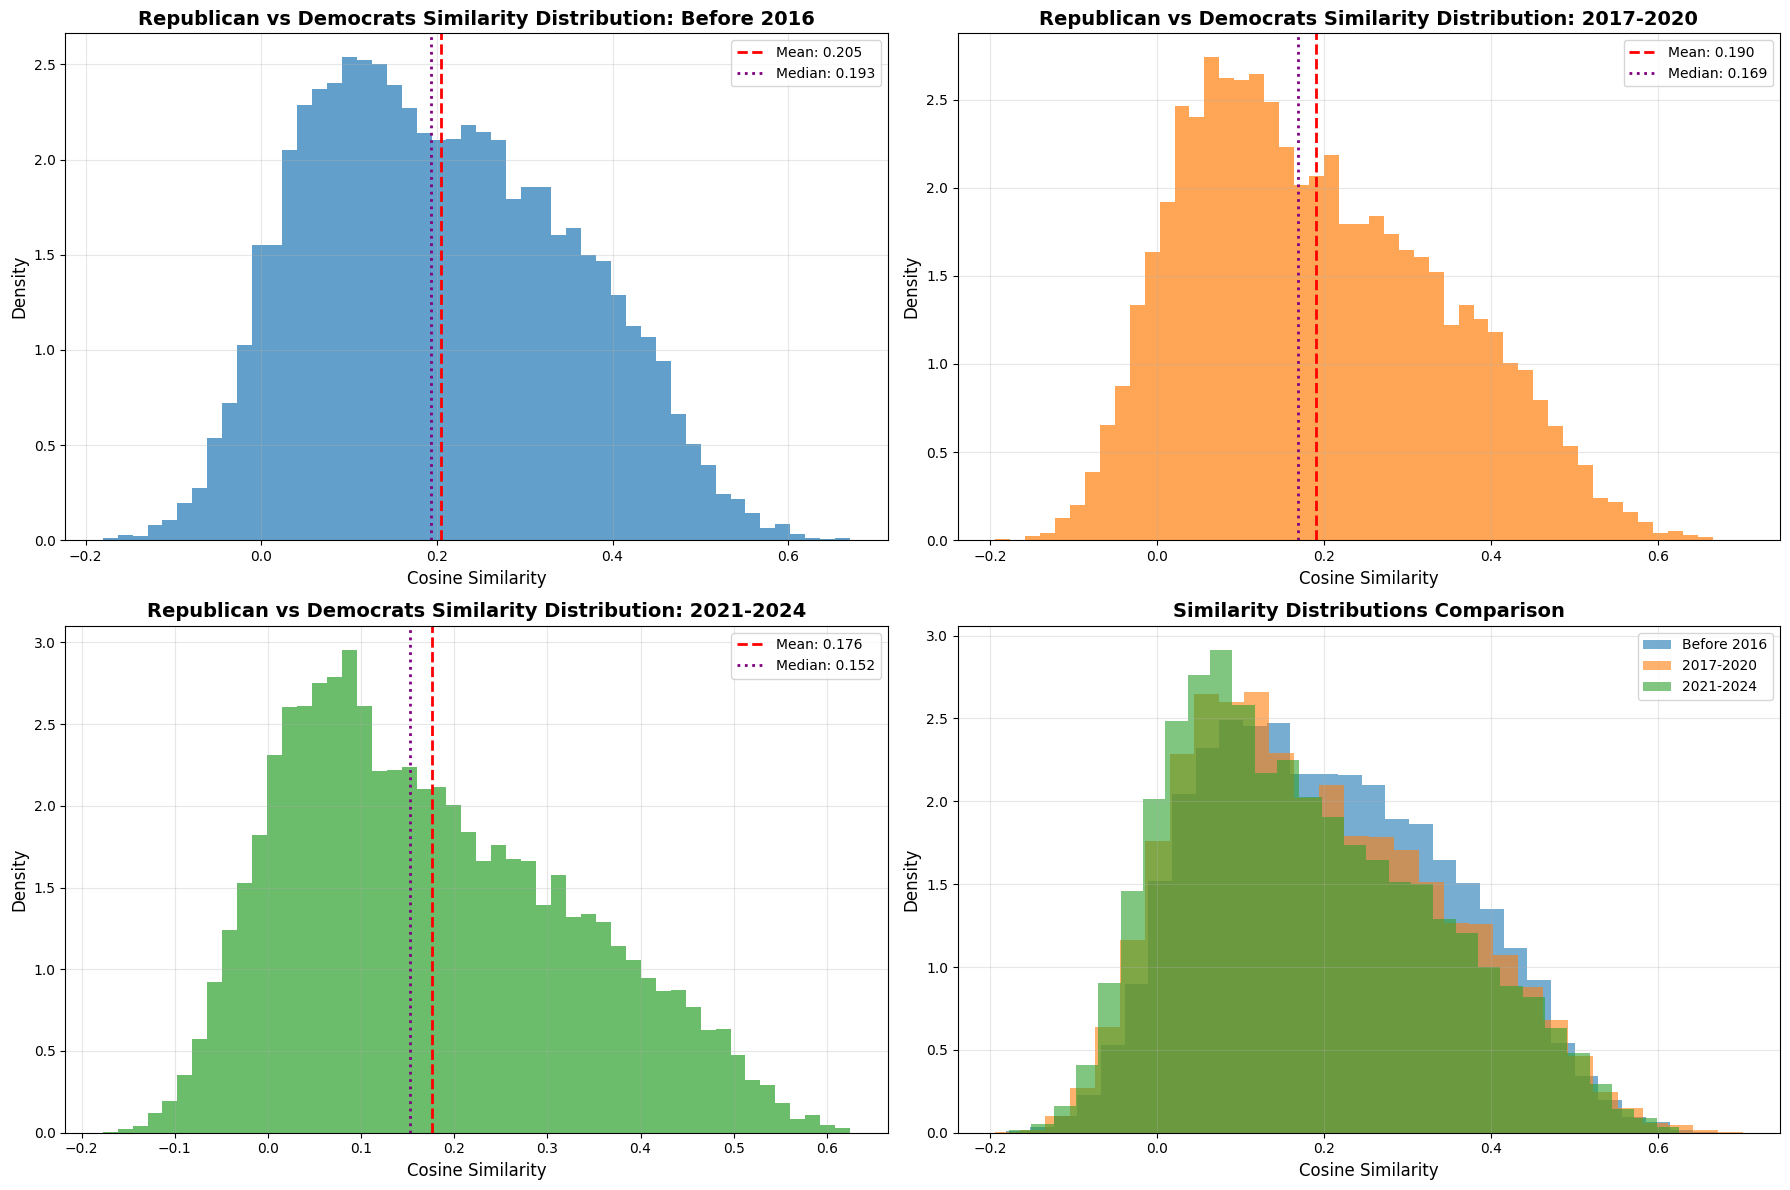

<Figure size 640x480 with 0 Axes>

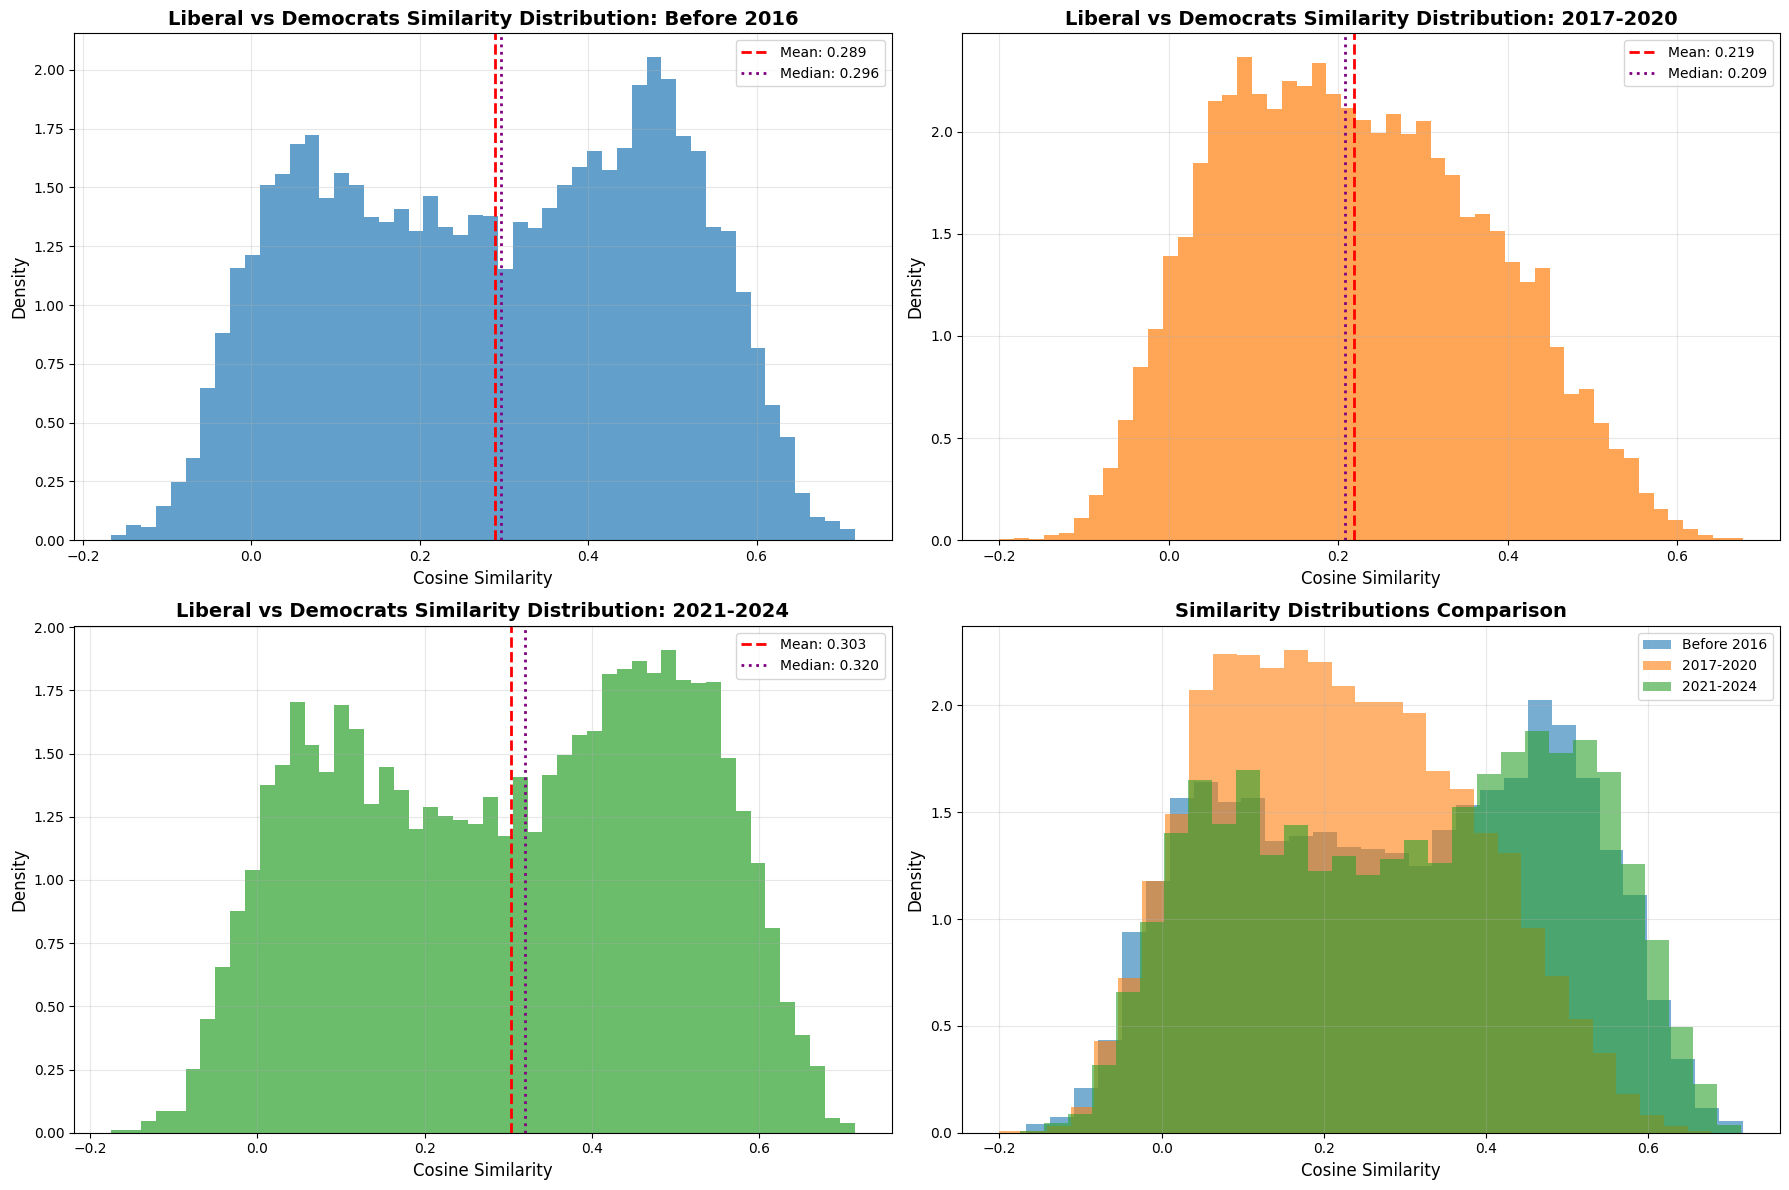

<Figure size 640x480 with 0 Axes>

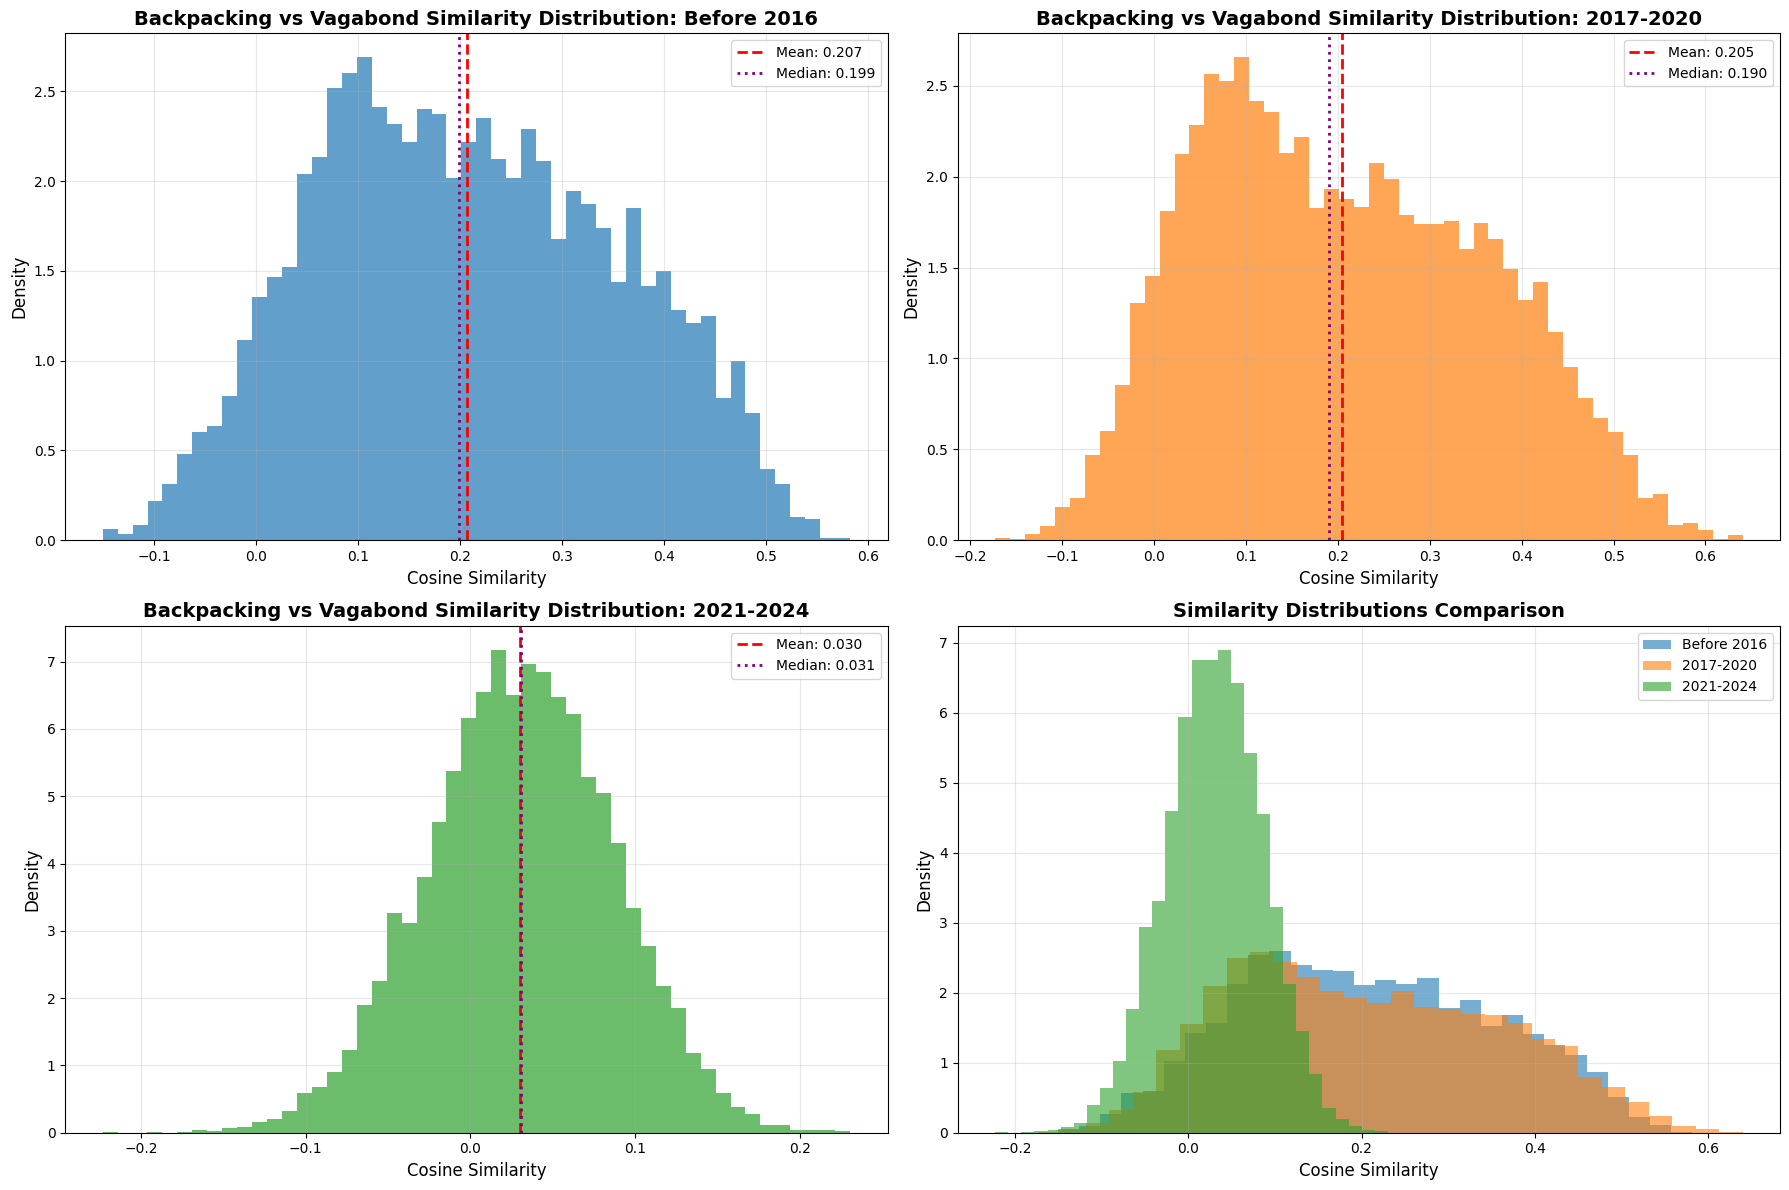

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_similarity_distributions(df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        std_sim = df['similarity'].std()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"output/v4/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()



# Run the analysis
# Read the CSV files
republican_conservative_before_2016 = pd.read_csv("output/v4/republican_conservative_before_2016.csv")
republican_conservative_2017_2020 = pd.read_csv("output/v4/republican_conservative_2017_2020.csv") 
republican_conservative_2021_2024 = pd.read_csv("output/v4/republican_conservative_2021_2024.csv")
republican_democrats_before_2016 = pd.read_csv("output/v4/republican_democrats_before_2016.csv")
republican_democrats_2017_2020 = pd.read_csv("output/v4/republican_democrats_2017_2020.csv")
republican_democrats_2021_2024 = pd.read_csv("output/v4/republican_democrats_2021_2024.csv")
liberal_democrats_before_2016 = pd.read_csv("output/v4/liberal_democrats_before_2016.csv")
liberal_democrats_2017_2020 = pd.read_csv("output/v4/liberal_democrats_2017_2020.csv")
liberal_democrats_2021_2024 = pd.read_csv("output/v4/liberal_democrats_2021_2024.csv")
backpacking_vagabond_before_2016 = pd.read_csv("output/v4/backpacking_vagabond_before_2016.csv")
backpacking_vagabond_2017_2020 = pd.read_csv("output/v4/backpacking_vagabond_2017_2020.csv")
backpacking_vagabond_2021_2024 = pd.read_csv("output/v4/backpacking_vagabond_2021_2024.csv")


analyze_similarity_distributions(
    republican_conservative_before_2016, 
    republican_conservative_2017_2020, 
    republican_conservative_2021_2024, 
    "Republican", 
    "Conservative"
    )

analyze_similarity_distributions(
    republican_democrats_before_2016, 
    republican_democrats_2017_2020, 
    republican_democrats_2021_2024, 
    "Republican", 
    "Democrats"
    )

analyze_similarity_distributions(
    liberal_democrats_before_2016, 
    liberal_democrats_2017_2020, 
    liberal_democrats_2021_2024, 
    "Liberal", 
    "Democrats"
    )

analyze_similarity_distributions(
    backpacking_vagabond_before_2016, 
    backpacking_vagabond_2017_2020, 
    backpacking_vagabond_2021_2024, 
    "Backpacking", 
    "Vagabond"
    )


In [6]:
# model v5

# Democrats vs Republicans
democrats_before_2016 = gensim.models.Word2Vec.load("models/model_v5/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/democrats_2021_2024.model")
liberal_before_2016 = gensim.models.Word2Vec.load("models/model_v5/liberal_before_2016.model")
liberal_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/liberal_2017_2020.model")
liberal_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/liberal_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load("models/model_v5/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/republican_2021_2024.model")
conservative_before_2016 = gensim.models.Word2Vec.load("models/model_v5/conservative_before_2016.model")
conservative_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/conservative_2017_2020.model")
conservative_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/conservative_2021_2024.model")
backpacking_before_2016 = gensim.models.Word2Vec.load("models/model_v5/backpacking_before_2016.model")
backpacking_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/backpacking_2017_2020.model")
backpacking_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/backpacking_2021_2024.model")
vagabond_before_2016 = gensim.models.Word2Vec.load("models/model_v5/vagabond_before_2016.model")
vagabond_2017_2020 = gensim.models.Word2Vec.load("models/model_v5/vagabond_2017_2020.model")
vagabond_2021_2024 = gensim.models.Word2Vec.load("models/model_v5/vagabond_2021_2024.model")

# Define output directory
output_dir = "output/v5"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016
compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    conservative_before_2016,
    "republican", 
    "conservative",
    "before_2016",
    output_file=f"{output_dir}/republican_conservative_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    democrats_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_before_2016, 
    democrats_before_2016,
    "liberal", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/liberal_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_before_2016, 
    vagabond_before_2016,
    "backpacking", 
    "vagabond",
    "before_2016",
    output_file=f"{output_dir}/backpacking_vagabond_before_2016.csv"
)

# 2017-2020
compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    conservative_2017_2020,
    "republican", 
    "conservative",
    "2017_2020",
    output_file=f"{output_dir}/republican_conservative_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    democrats_2017_2020,
    "republican", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/republican_democrats_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_2017_2020, 
    democrats_2017_2020,
    "liberal", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/liberal_democrats_2017_2020.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_2017_2020, 
    vagabond_2017_2020,
    "backpacking", 
    "vagabond",
    "2017_2020",
    output_file=f"{output_dir}/backpacking_vagabond_2017_2020.csv"
)

# 2021-2024
compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    conservative_2021_2024,
    "republican", 
    "conservative",
    "2021_2024",
    output_file=f"{output_dir}/republican_conservative_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    democrats_2021_2024,
    "republican", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/republican_democrats_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    liberal_2021_2024, 
    democrats_2021_2024,
    "liberal", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/liberal_democrats_2021_2024.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_2021_2024, 
    vagabond_2021_2024,
    "backpacking", 
    "vagabond",
    "2021_2024",
    output_file=f"{output_dir}/backpacking_vagabond_2021_2024.csv"
)


print("\nAnalysis complete. Generated 12 comparison files.")


Comparing models:
before_2016: Common vocabulary between republican and conservative: 16237 words
Results saved to output/v5/republican_conservative_before_2016.csv
before_2016: Common vocabulary between republican and democrats: 10956 words
Results saved to output/v5/republican_democrats_before_2016.csv
before_2016: Common vocabulary between liberal and democrats: 10956 words
Results saved to output/v5/liberal_democrats_before_2016.csv
before_2016: Common vocabulary between backpacking and vagabond: 32071 words
Results saved to output/v5/backpacking_vagabond_before_2016.csv
2017_2020: Common vocabulary between republican and conservative: 19243 words
Results saved to output/v5/republican_conservative_2017_2020.csv
2017_2020: Common vocabulary between republican and democrats: 16554 words
Results saved to output/v5/republican_democrats_2017_2020.csv
2017_2020: Common vocabulary between liberal and democrats: 16554 words
Results saved to output/v5/liberal_democrats_2017_2020.csv
2017_2

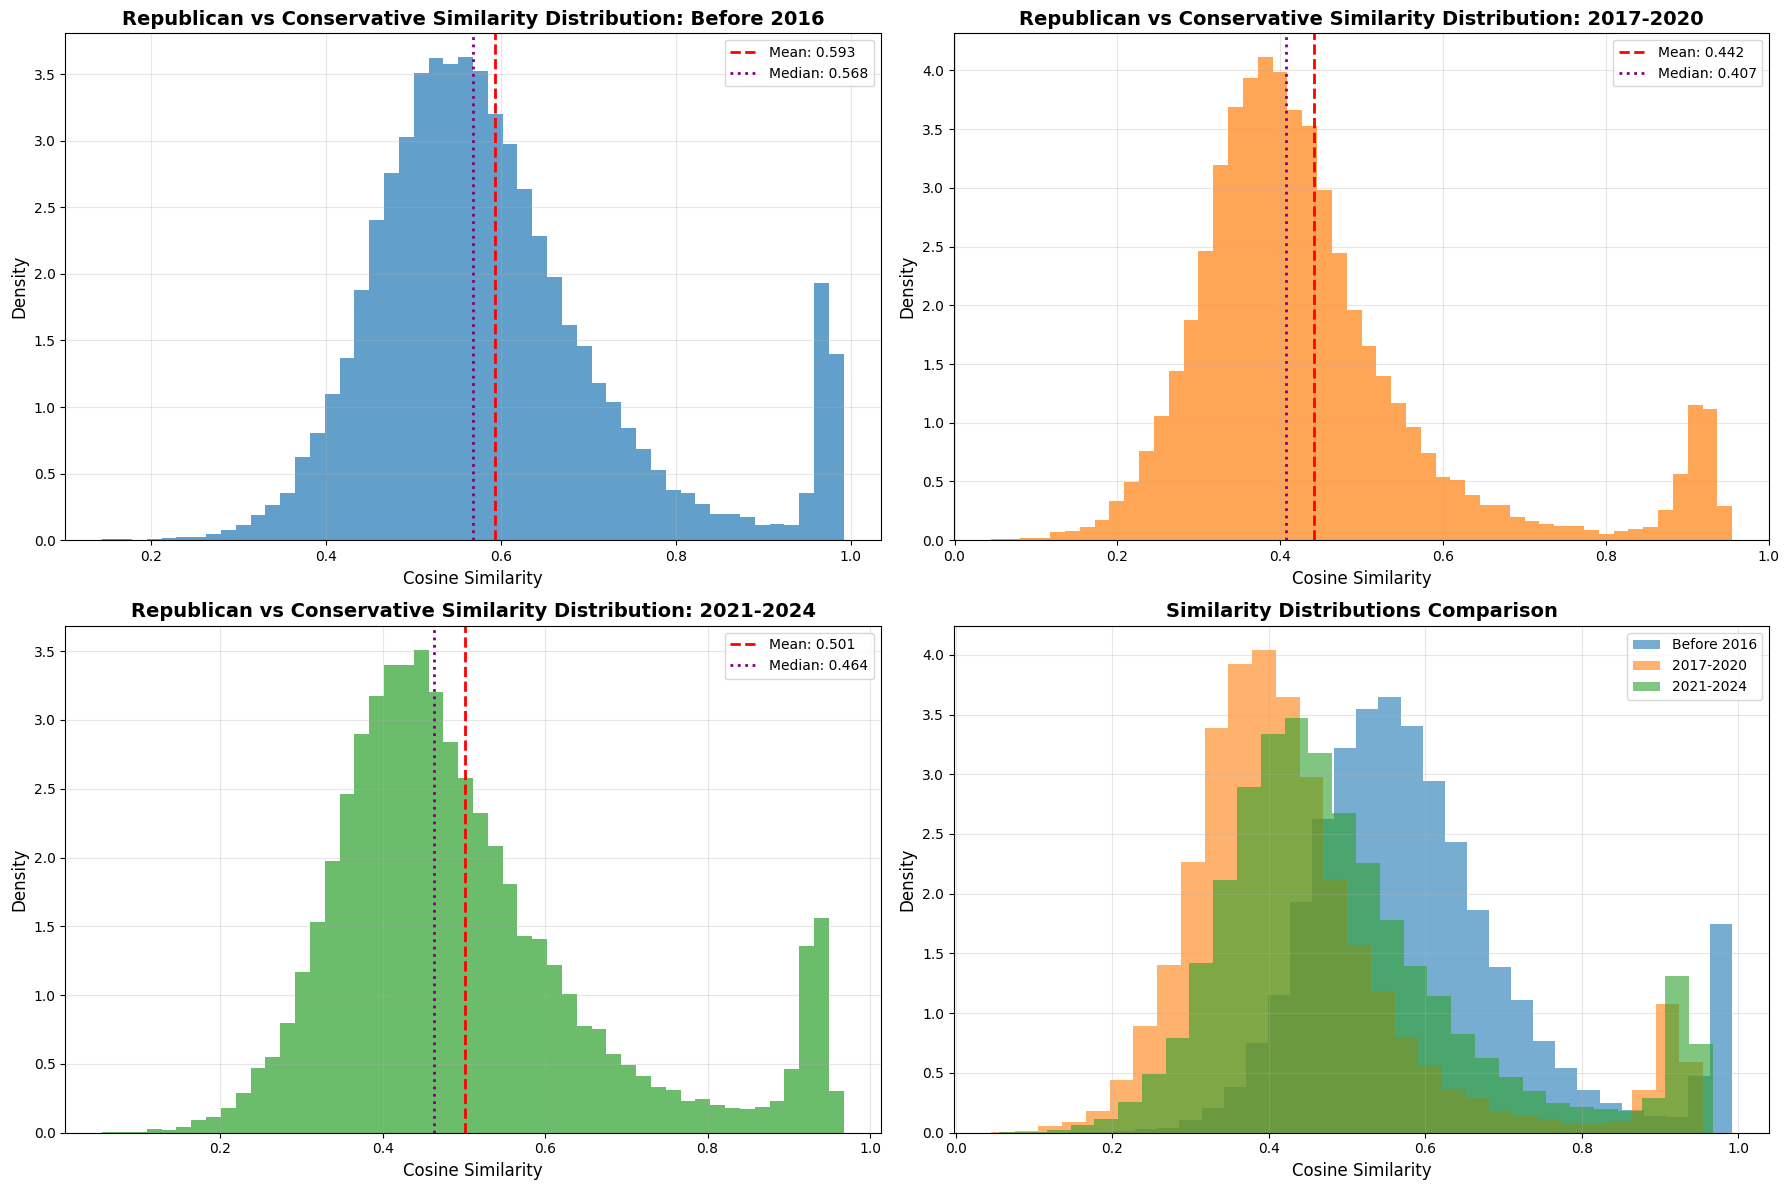

<Figure size 640x480 with 0 Axes>

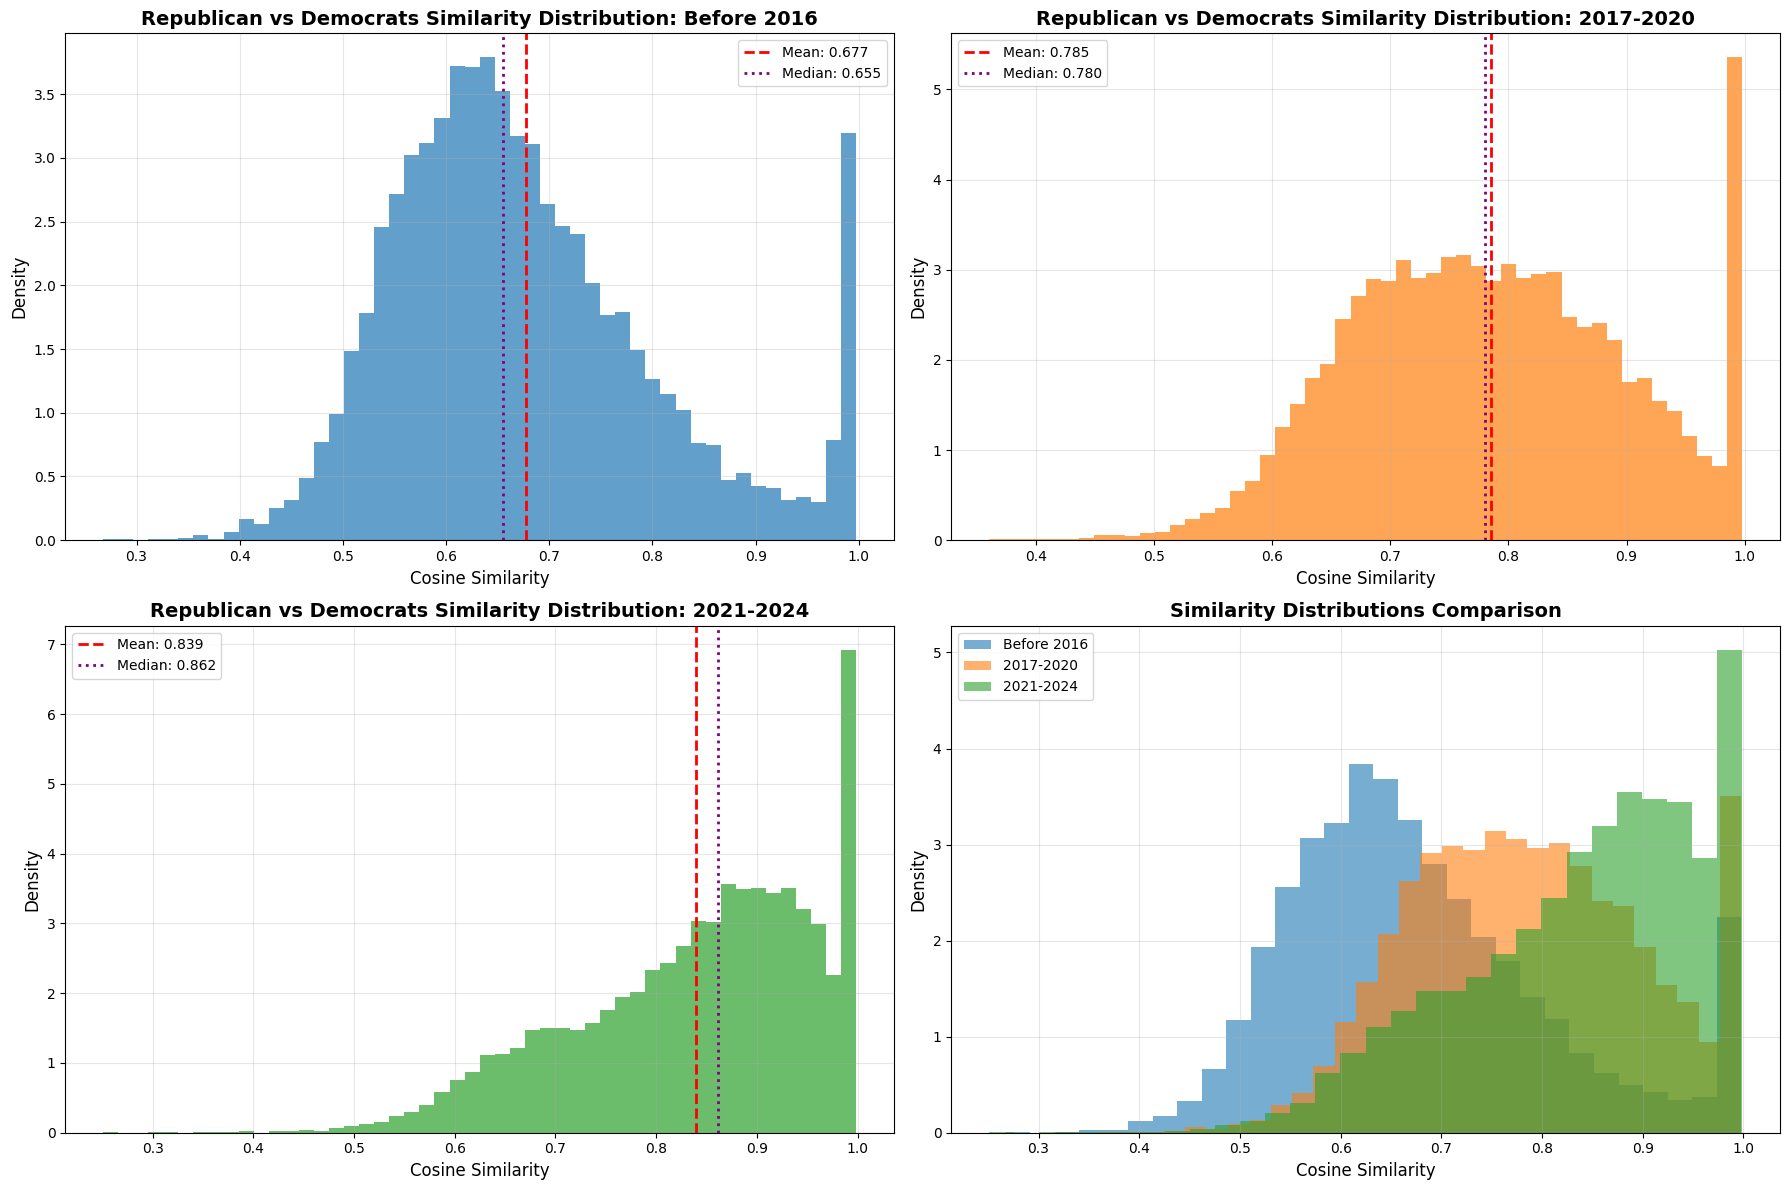

<Figure size 640x480 with 0 Axes>

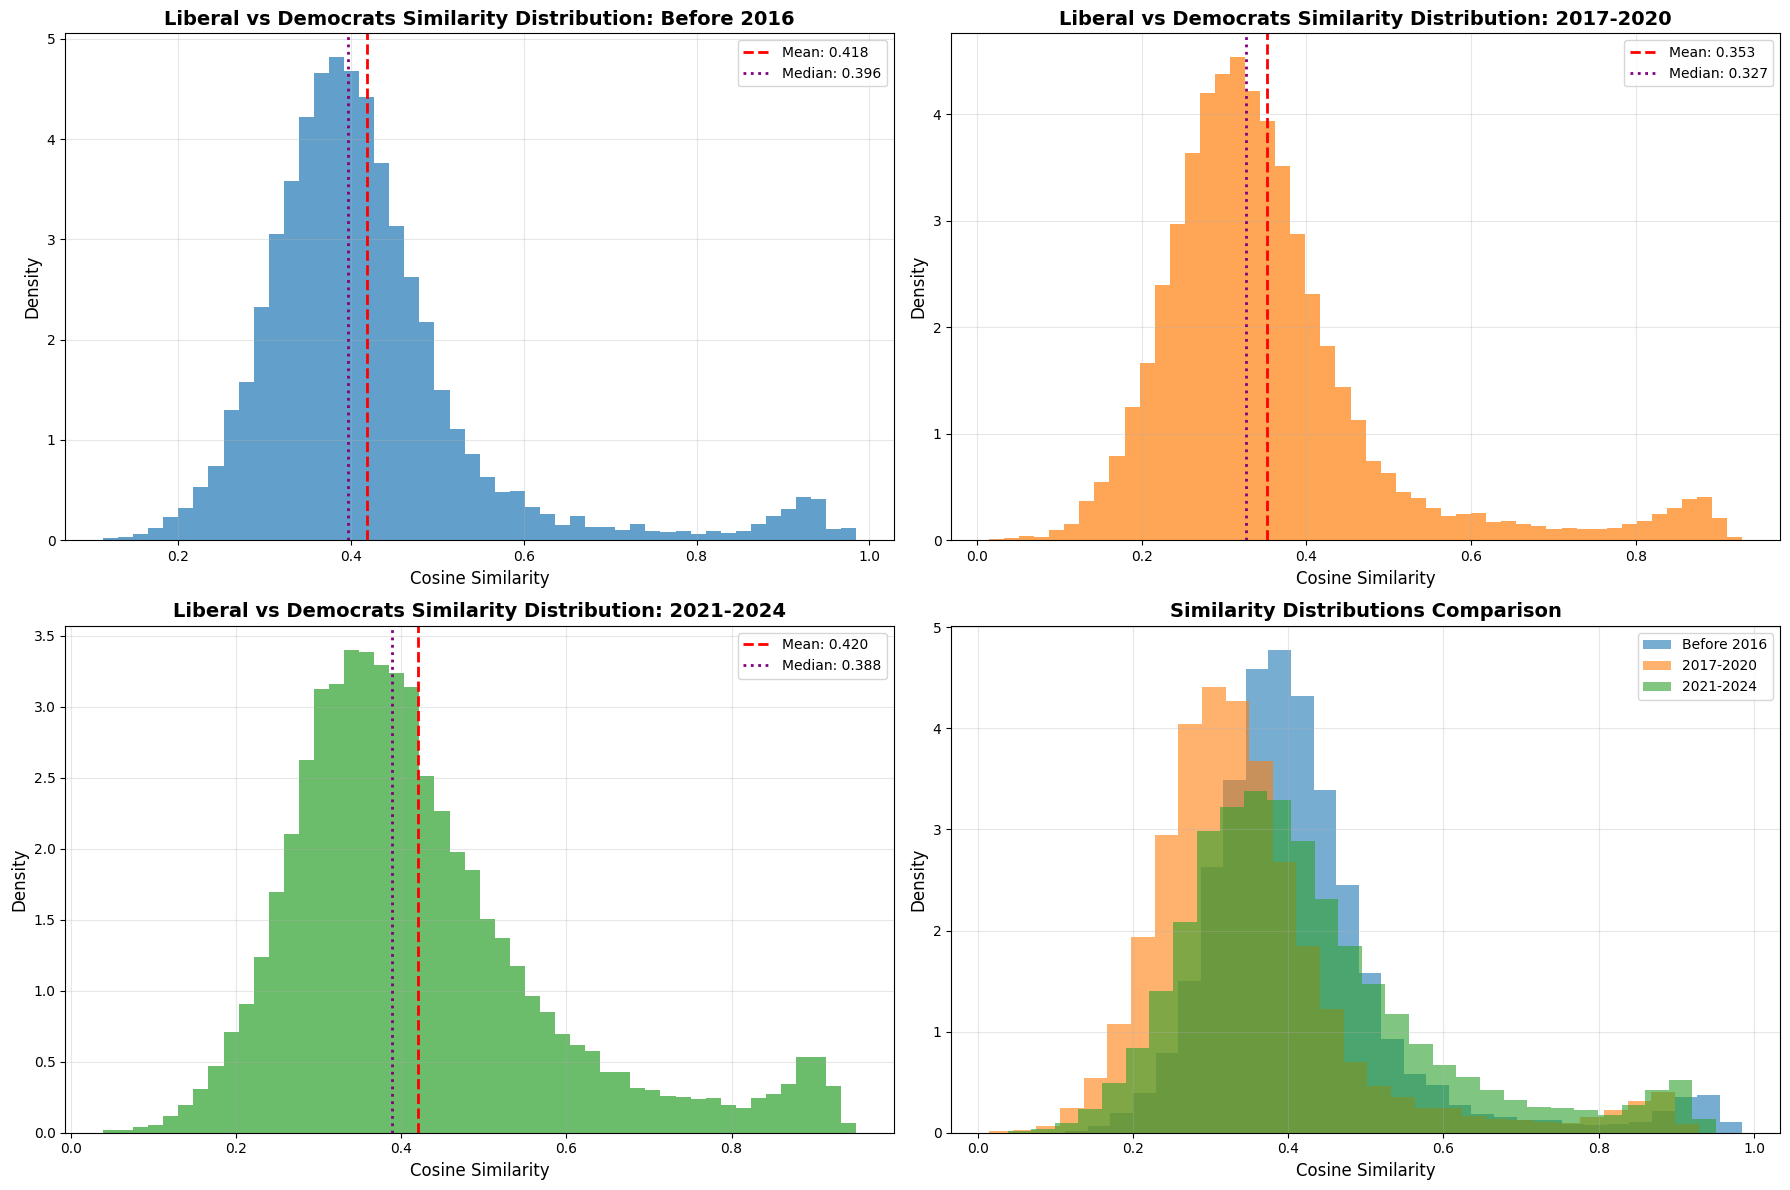

<Figure size 640x480 with 0 Axes>

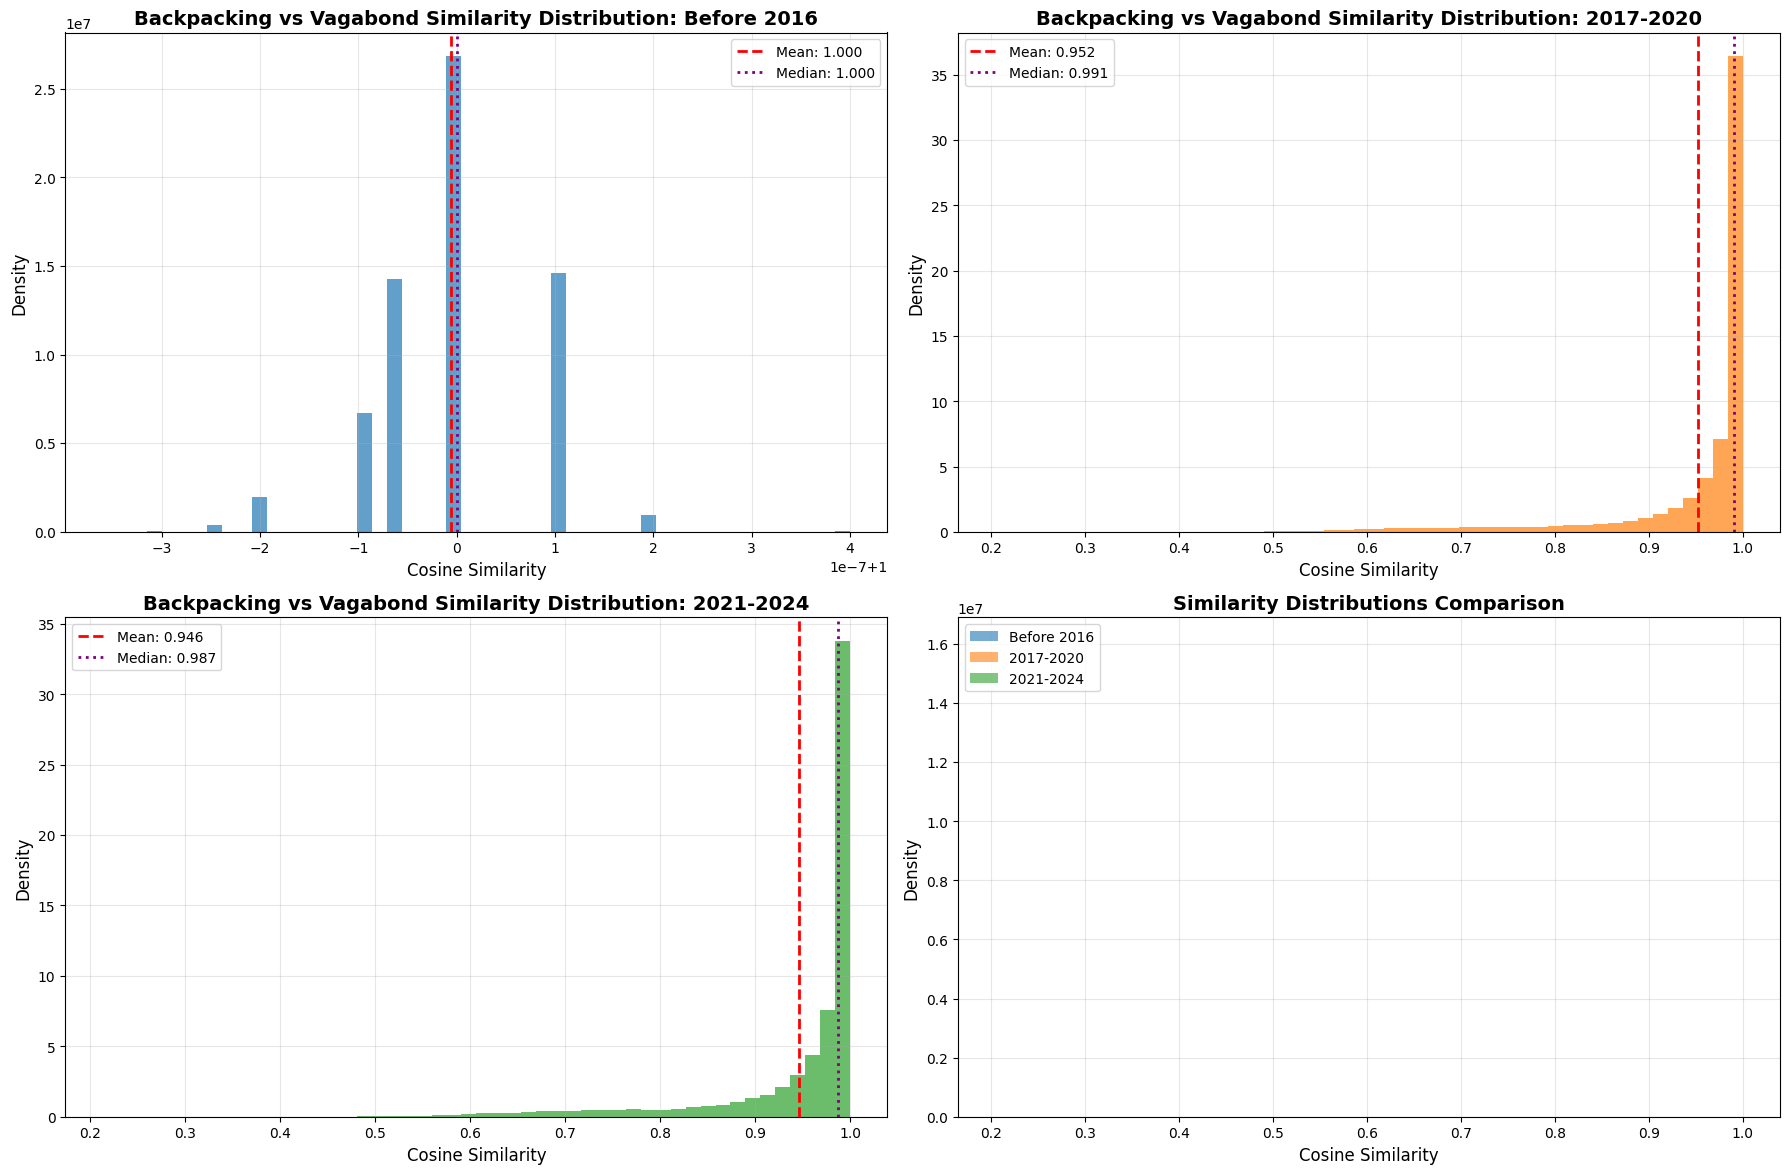

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_similarity_distributions(df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        std_sim = df['similarity'].std()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"output/v5/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()


# Run the analysis
# Read the CSV files
republican_conservative_before_2016 = pd.read_csv("output/v5/republican_conservative_before_2016.csv")
republican_conservative_2017_2020 = pd.read_csv("output/v5/republican_conservative_2017_2020.csv") 
republican_conservative_2021_2024 = pd.read_csv("output/v5/republican_conservative_2021_2024.csv")
republican_democrats_before_2016 = pd.read_csv("output/v5/republican_democrats_before_2016.csv")
republican_democrats_2017_2020 = pd.read_csv("output/v5/republican_democrats_2017_2020.csv")
republican_democrats_2021_2024 = pd.read_csv("output/v5/republican_democrats_2021_2024.csv")
liberal_democrats_before_2016 = pd.read_csv("output/v5/liberal_democrats_before_2016.csv")
liberal_democrats_2017_2020 = pd.read_csv("output/v5/liberal_democrats_2017_2020.csv")
liberal_democrats_2021_2024 = pd.read_csv("output/v5/liberal_democrats_2021_2024.csv")
backpacking_vagabond_before_2016 = pd.read_csv("output/v5/backpacking_vagabond_before_2016.csv")
backpacking_vagabond_2017_2020 = pd.read_csv("output/v5/backpacking_vagabond_2017_2020.csv")
backpacking_vagabond_2021_2024 = pd.read_csv("output/v5/backpacking_vagabond_2021_2024.csv")


analyze_similarity_distributions(
    republican_conservative_before_2016, 
    republican_conservative_2017_2020, 
    republican_conservative_2021_2024, 
    "Republican", 
    "Conservative"
    )

analyze_similarity_distributions(
    republican_democrats_before_2016, 
    republican_democrats_2017_2020, 
    republican_democrats_2021_2024, 
    "Republican", 
    "Democrats"
    )

analyze_similarity_distributions(
    liberal_democrats_before_2016, 
    liberal_democrats_2017_2020, 
    liberal_democrats_2021_2024, 
    "Liberal", 
    "Democrats"
    )

analyze_similarity_distributions(
    backpacking_vagabond_before_2016, 
    backpacking_vagabond_2017_2020, 
    backpacking_vagabond_2021_2024, 
    "Backpacking", 
    "Vagabond"
    )
